In [1]:
%load_ext autoreload
%autoreload 2

import sys, h5py, numpy as np, scipy.stats, healpy as hp, tqdm.notebook
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
#mpl.rcParams['figure.figsize'] = (6, 4)

# Use Saved Stan Results

In [2]:
eps=1e-10

lmax = 20
lengthscale = 0.3

M_bins = np.arange(10,21.1,1)
M = M_bins.shape[0]-1
C = 1
nside=32
nside_original = 128
resize = int((nside_original/nside)**2+0.1)

In [3]:
box={}; nside_original = 128
box['n']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
box['k']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    for i, mag in tqdm.notebook.tqdm(enumerate(hf['magval']), total=len(hf['magval'])):
        if (mag+eps<M_bins[0])|(mag+eps>M_bins[-1]): continue
        hpx = hf[str(i)]['hpx'][...]//resize
        M_idx = np.sum(M_bins<mag+eps).astype(int) - 1
        box['n'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['n'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5, 
                                                     statistic='sum').statistic.astype(int)
        box['k'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['k_ast'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5, 
                                                     statistic='sum').statistic.astype(int)
        
lengthscale_m = lengthscale/(M_bins[1]-M_bins[0])
lengthscale_c = 1.

  0%|          | 0/213 [00:00<?, ?it/s]

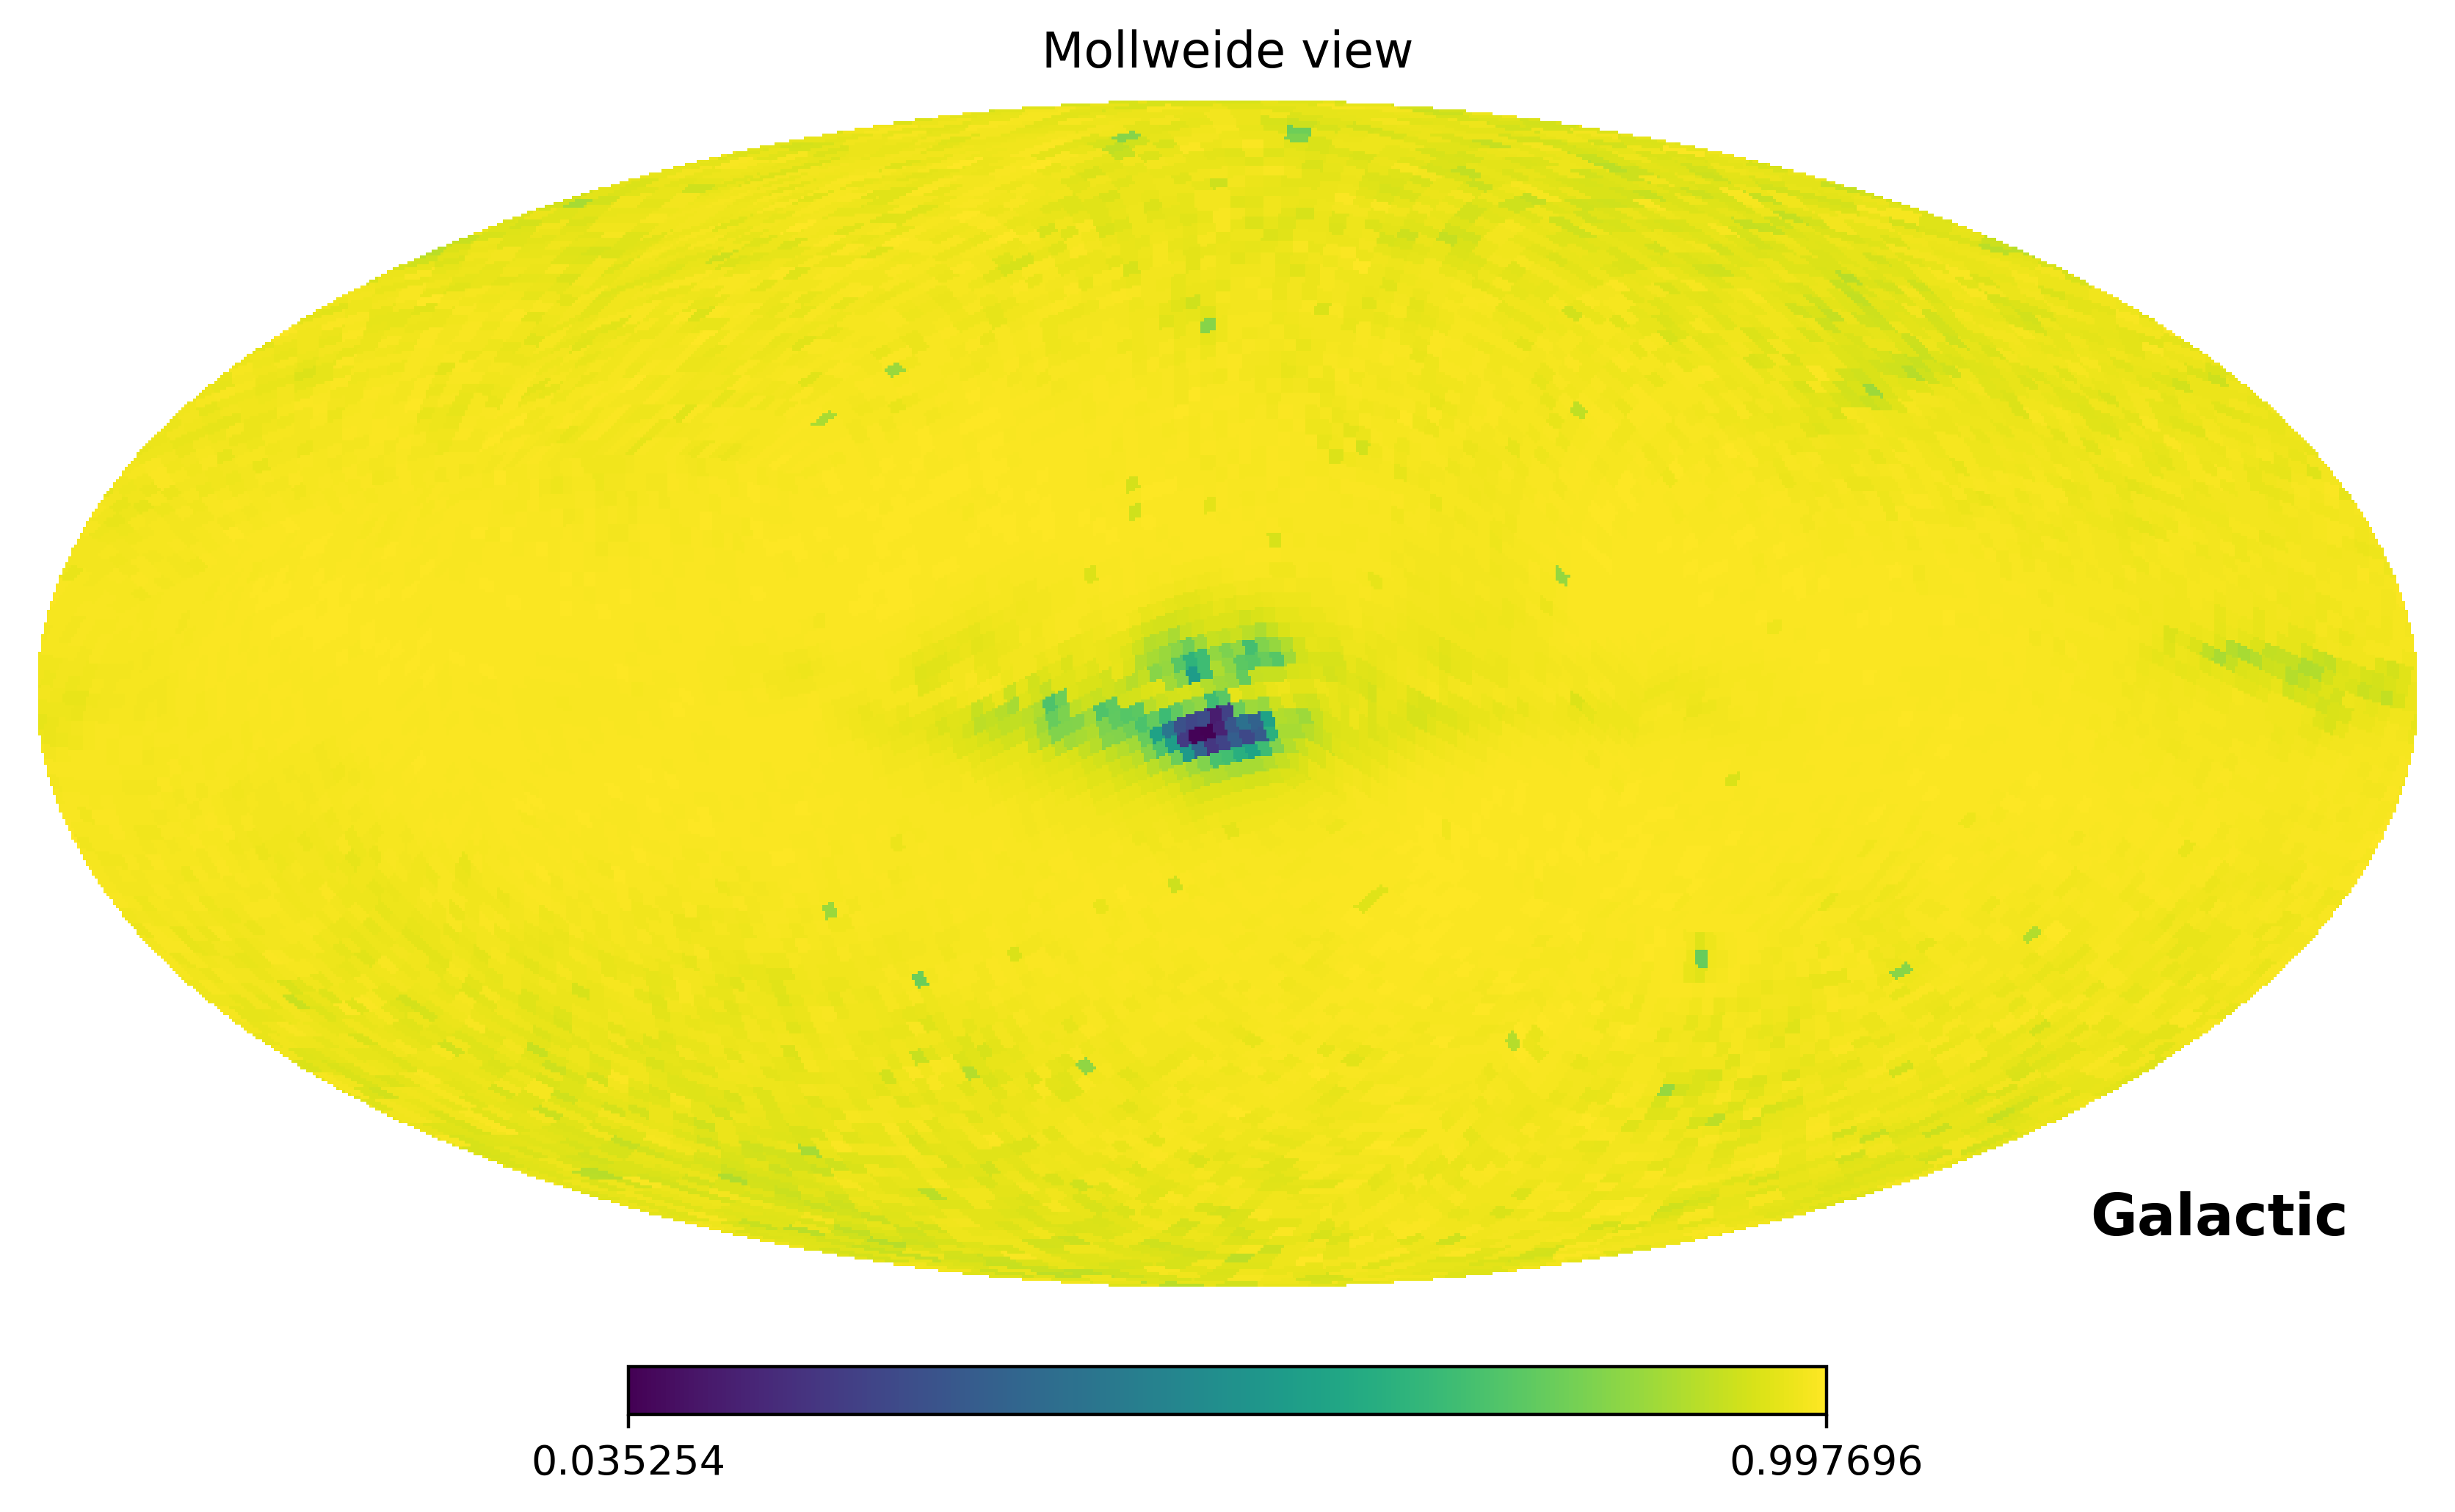

In [5]:
hp.mollview((box['k'][9,0]+1)/(box['n'][9,0]+2), nest=True, coord=['C','G'])

In [4]:
# Import hammer
from SelectionFunctionHammer import Hammer

In [5]:
hammer = Hammer(k = box['k'],
                n = box['n'],
                axes = ['magnitude','colour','position'],
                nest = True,
                lmax = lmax,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                file_root = f"lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}",
                )

Spherical harmonic file loaded
11 11
1 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionHammer/StanModels/magnitude_colour_position_sparse


82.64% sparsity
0.00% sparsity


In [8]:
# Run hammer
hammer.optimize(number_of_iterations = 10000)

INFO:cmdstanpy:start chain 1


Running optimisation


INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 141.6 seconds
Convergence information stored in ./StanOutput/lmax20_nside32_M11_C1_l0.3_convergence.txt
Optimum values stored in ./StanOutput/lmax20_nside32_M11_C1_l0.3_results.h5


In [9]:
# Print convergence information
hammer.print_convergence(number_of_lines = 10)

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1499  -3.18716e+07     0.0449896       177.819           1           1     1637   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1599  -3.18715e+07     0.0123397       274.514      0.2696           1     1747   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1699  -3.18715e+07     0.0273158       491.876           1           1     1857   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1761  -3.18715e+07   0.000969668       82.3709           1           1     1923   

Optimization terminated normally: 

  Convergence detected: relative gradient magnitude is below tolerance



In [77]:
hammer.stan_output_directory, hammer.file_root

('./StanOutput/', 'lmax50_nside32_M11_C1_l0.3')

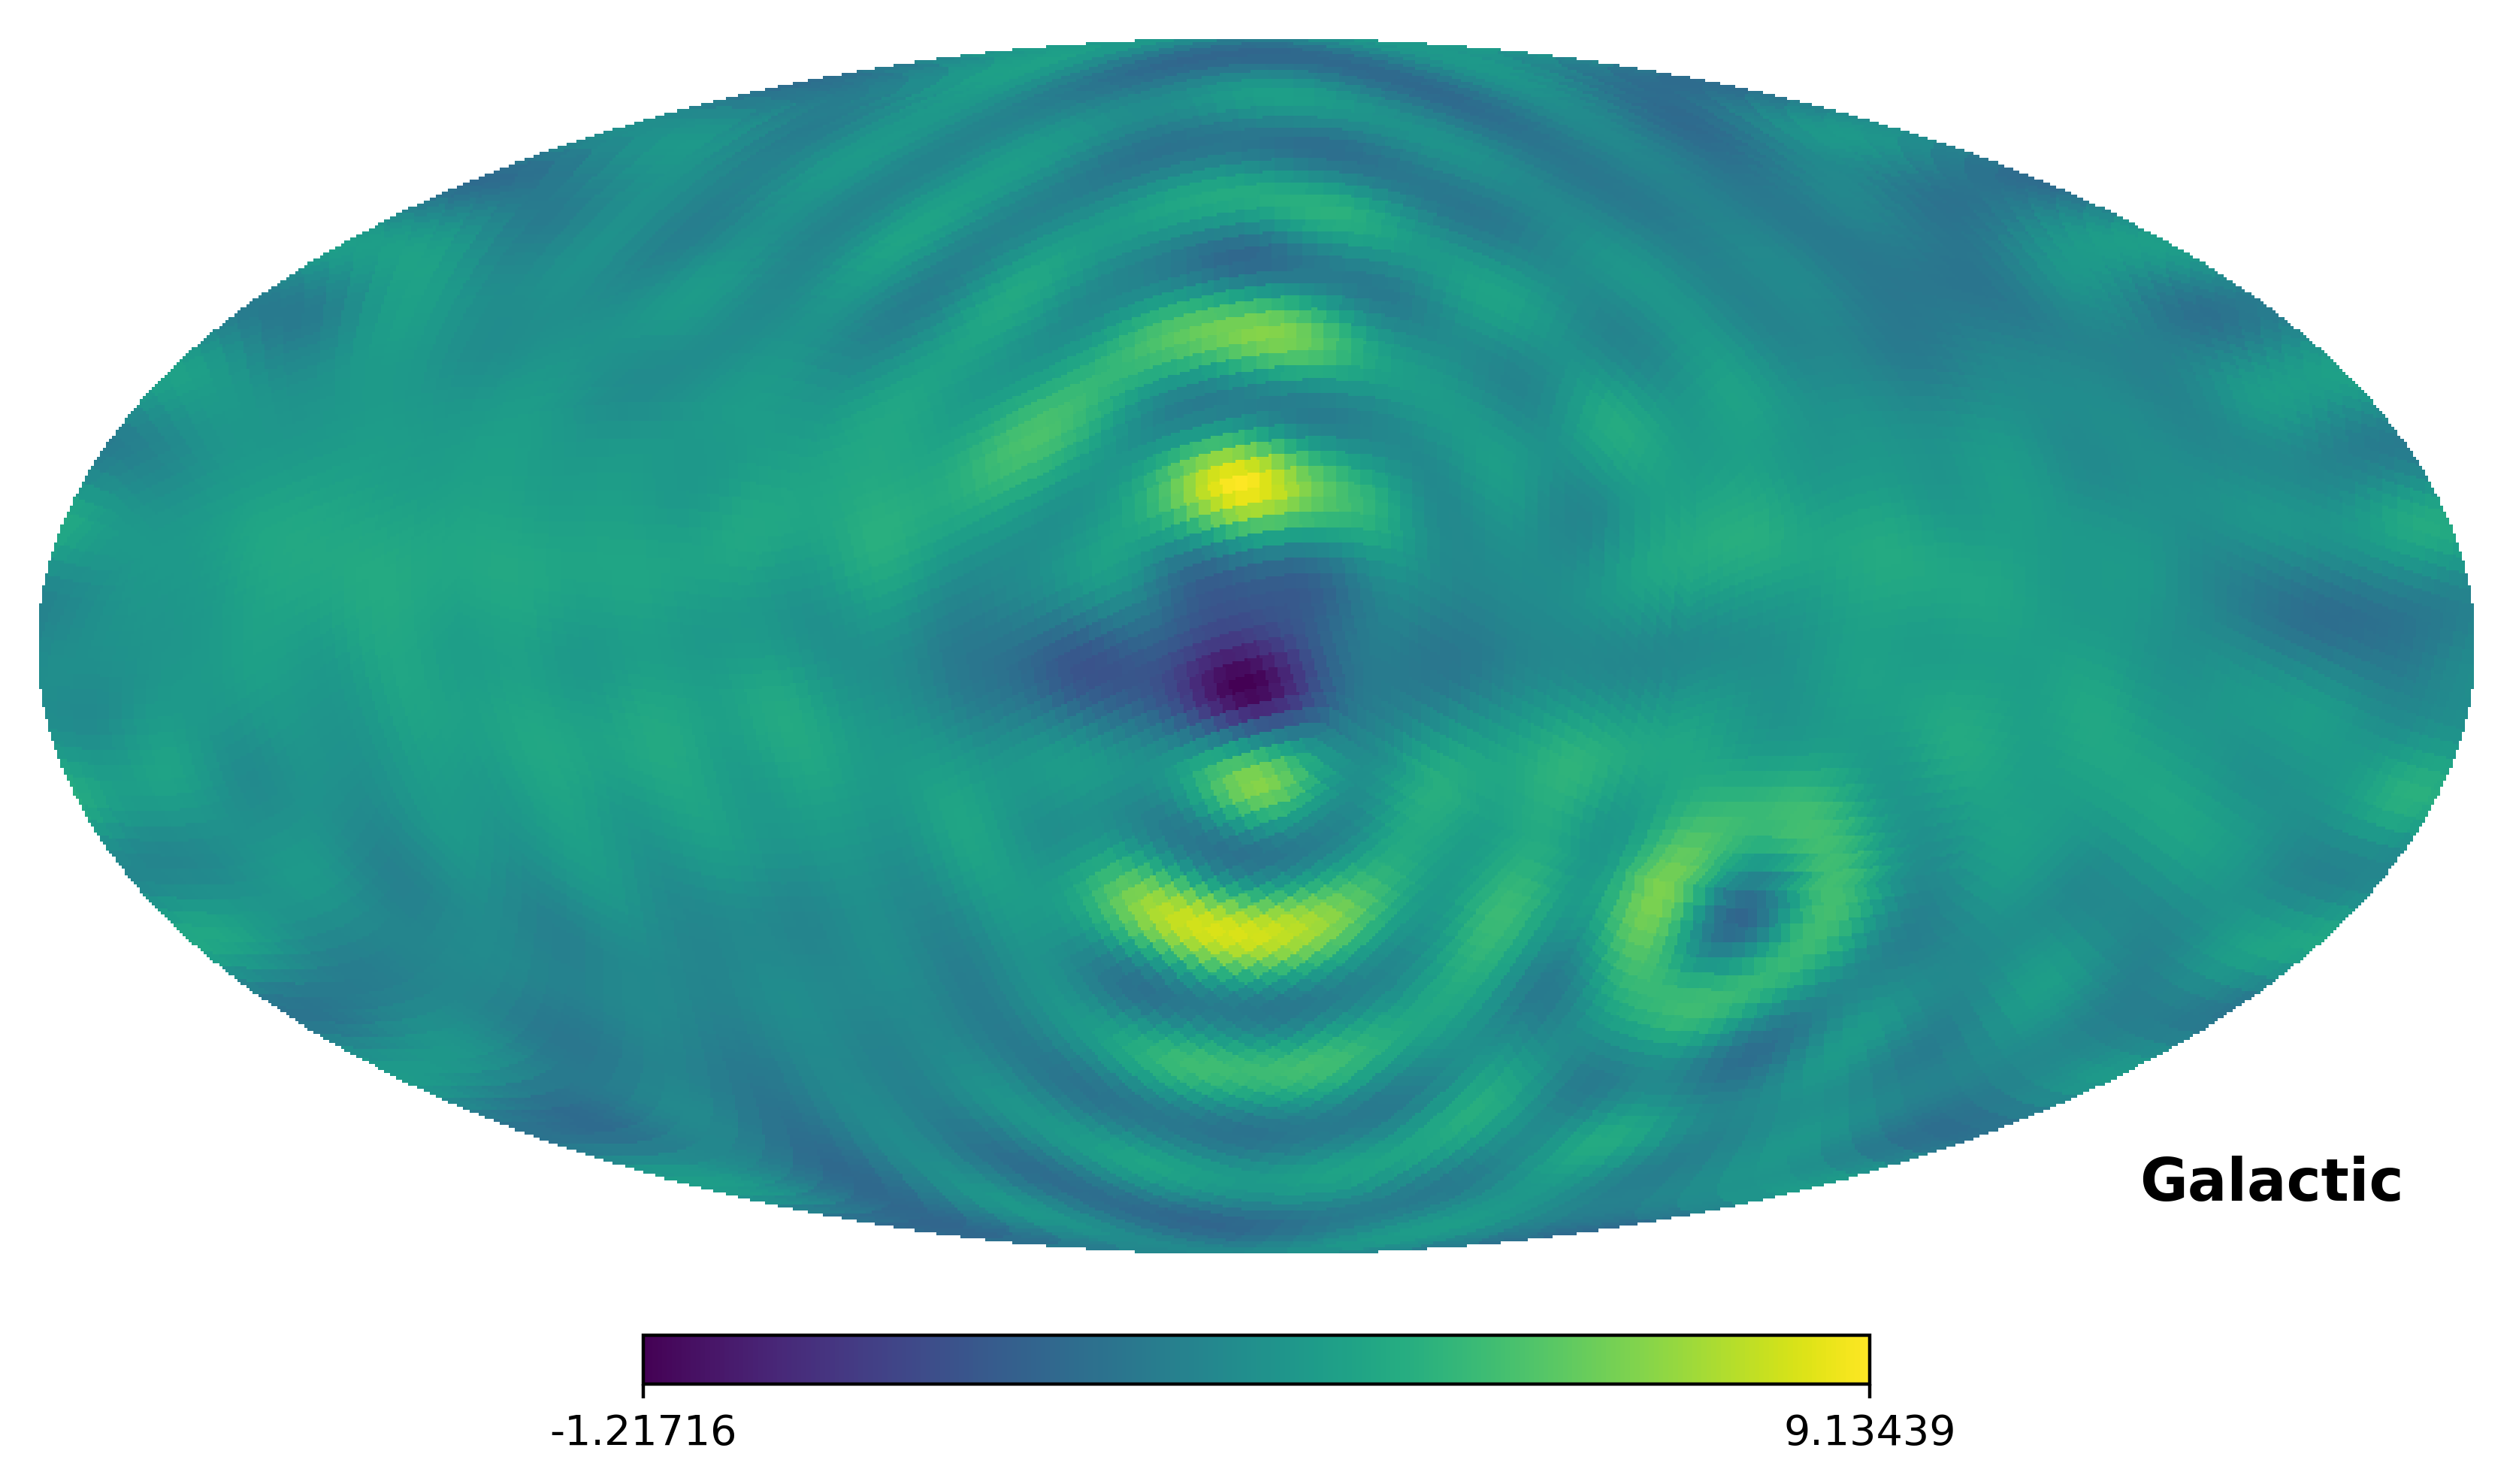

In [11]:
hp.mollview(hammer.optimum_x[9,0],nest=True,coord=['C','G'], title='')

# Testing code: Run model manually!

In [117]:
# Run manually
_stan_optimum = hammer.stan_model.optimize(data = hammer.stan_input, iter = 1000, 
                                           output_dir = hammer.stan_output_directory)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [ ]:
# Generate Figures

In [14]:
result = {}
with h5py.File(f'StanOutput/lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_results.h5', 'r') as hf:
    result = {k:v[...] for k,v in hf.items()}

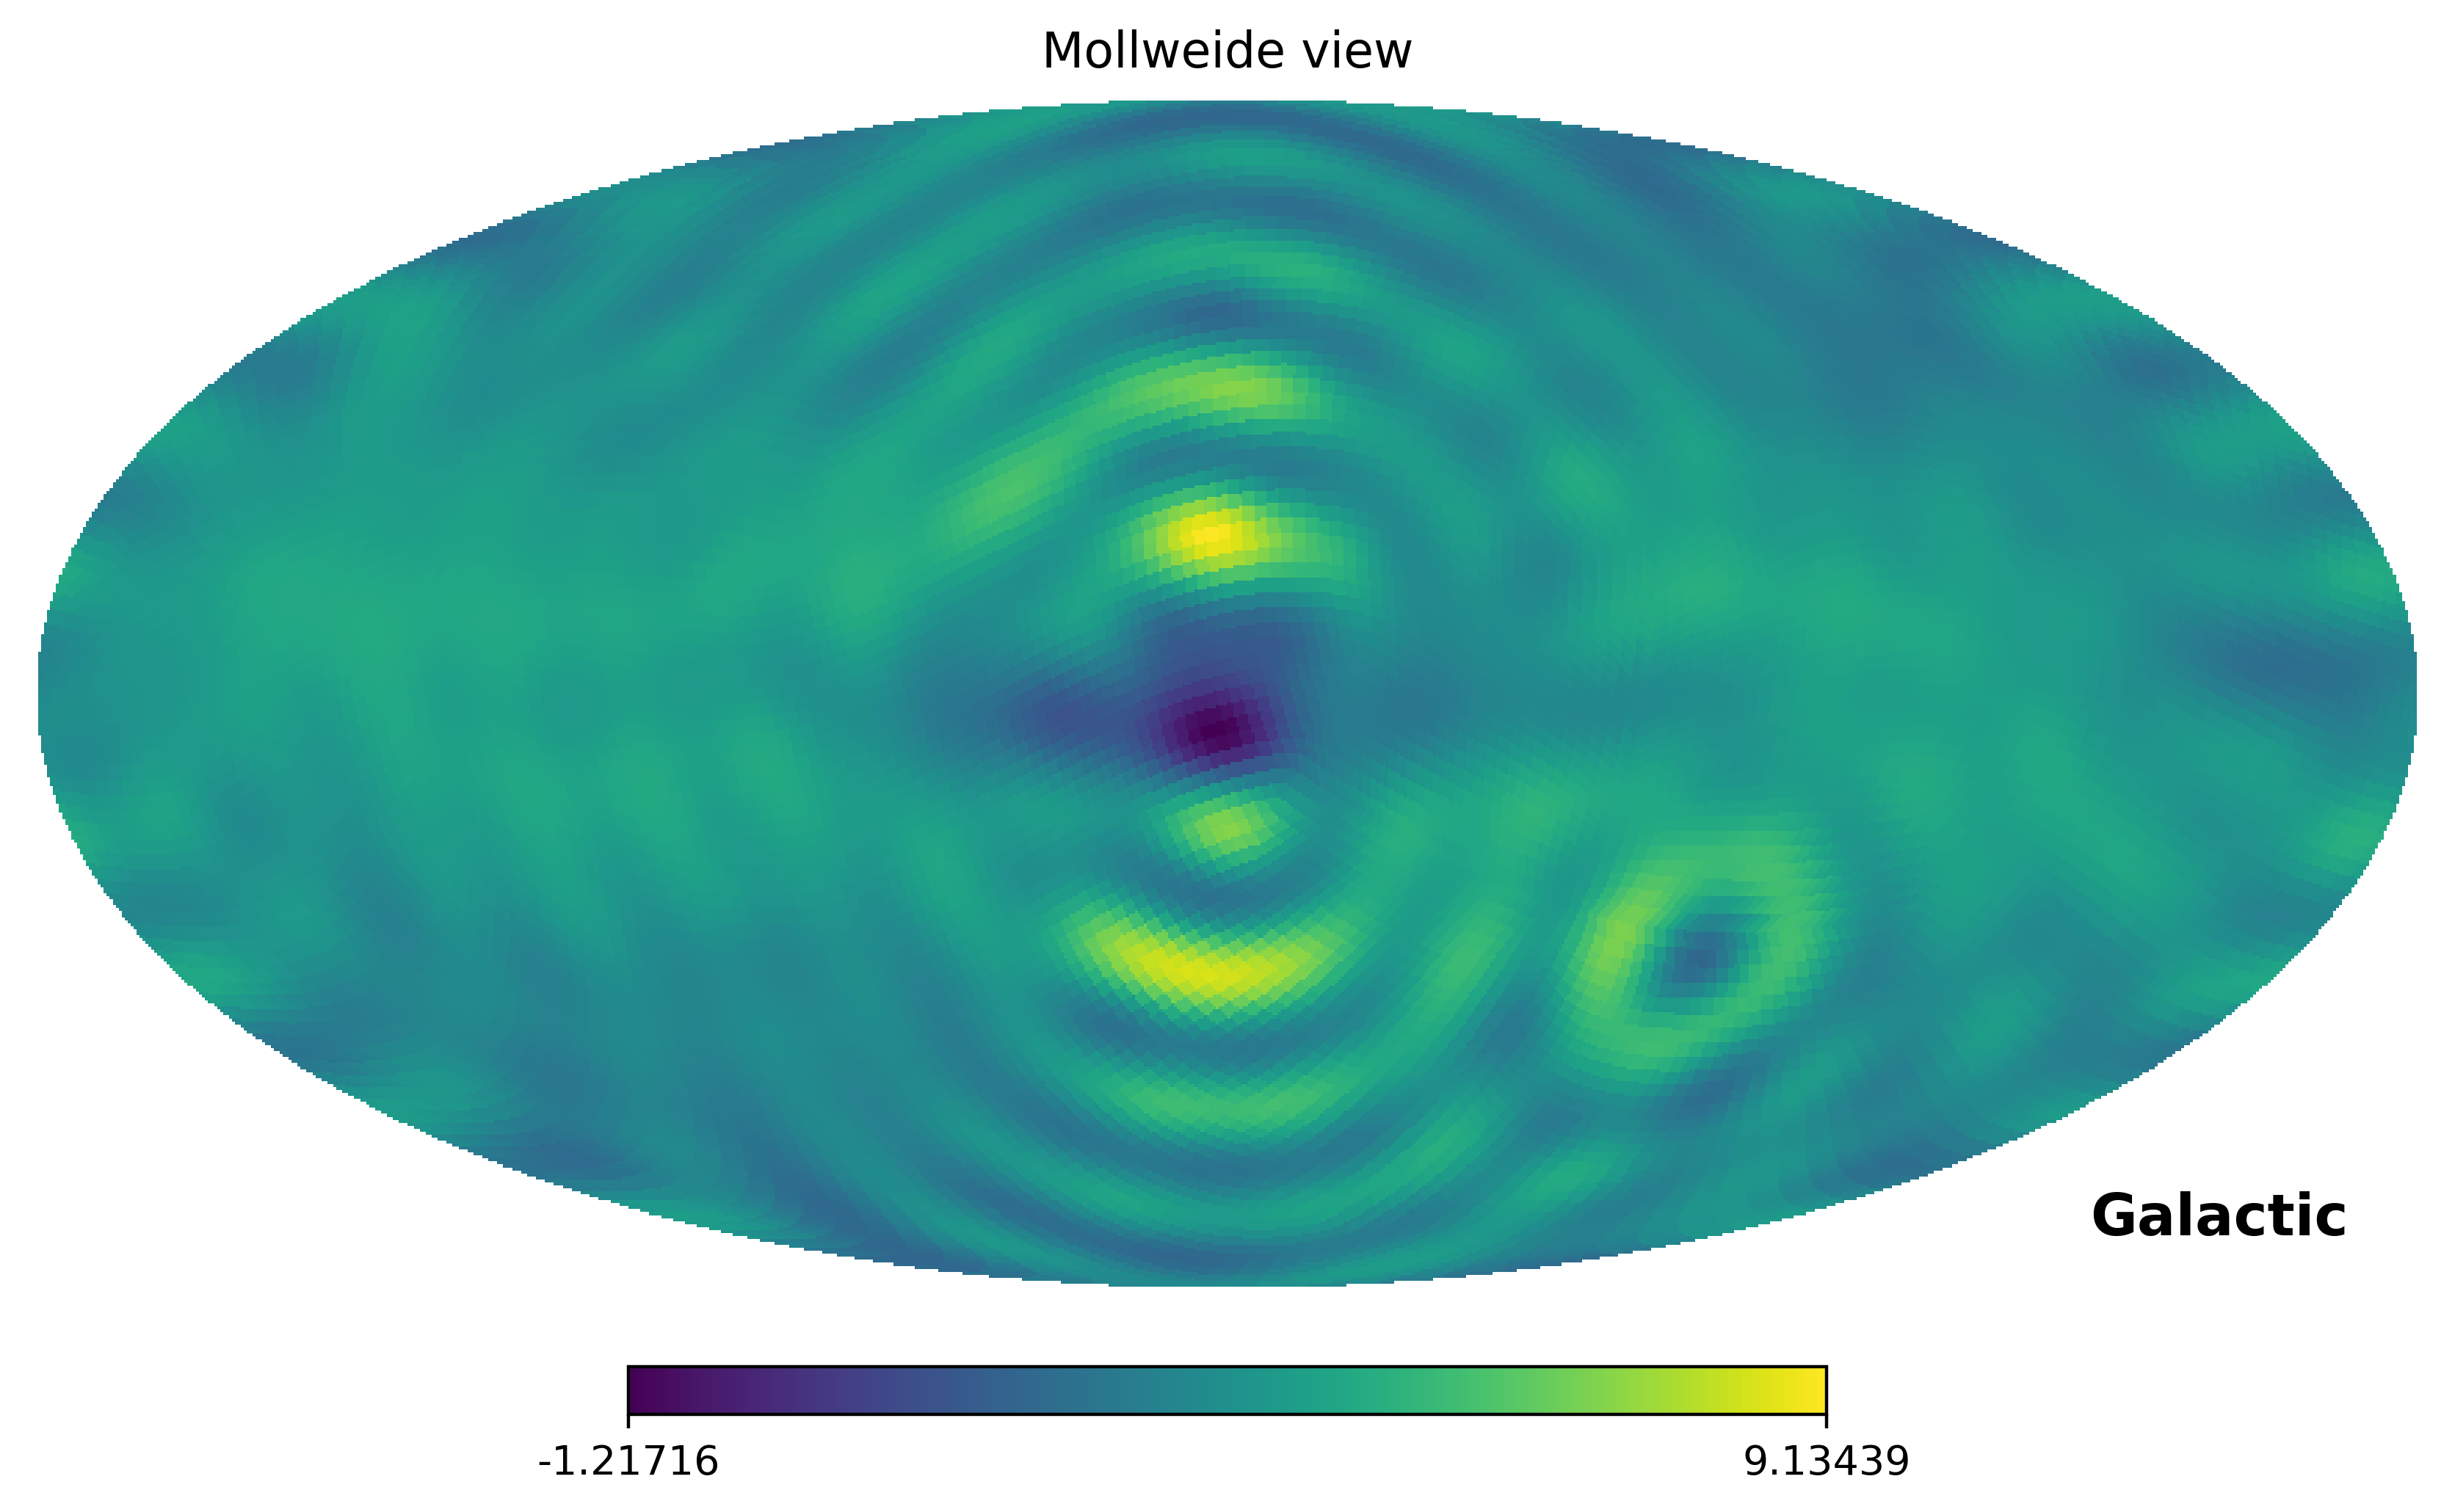

In [16]:
hp.mollview(result['x'][9,0],nest=True,coord=['C','G'],cmap='viridis')

In [8]:
hammer._lower[10], hammer._upper[10]

(375, 385)

In [19]:
result['a'].shape

(441, 11, 1)

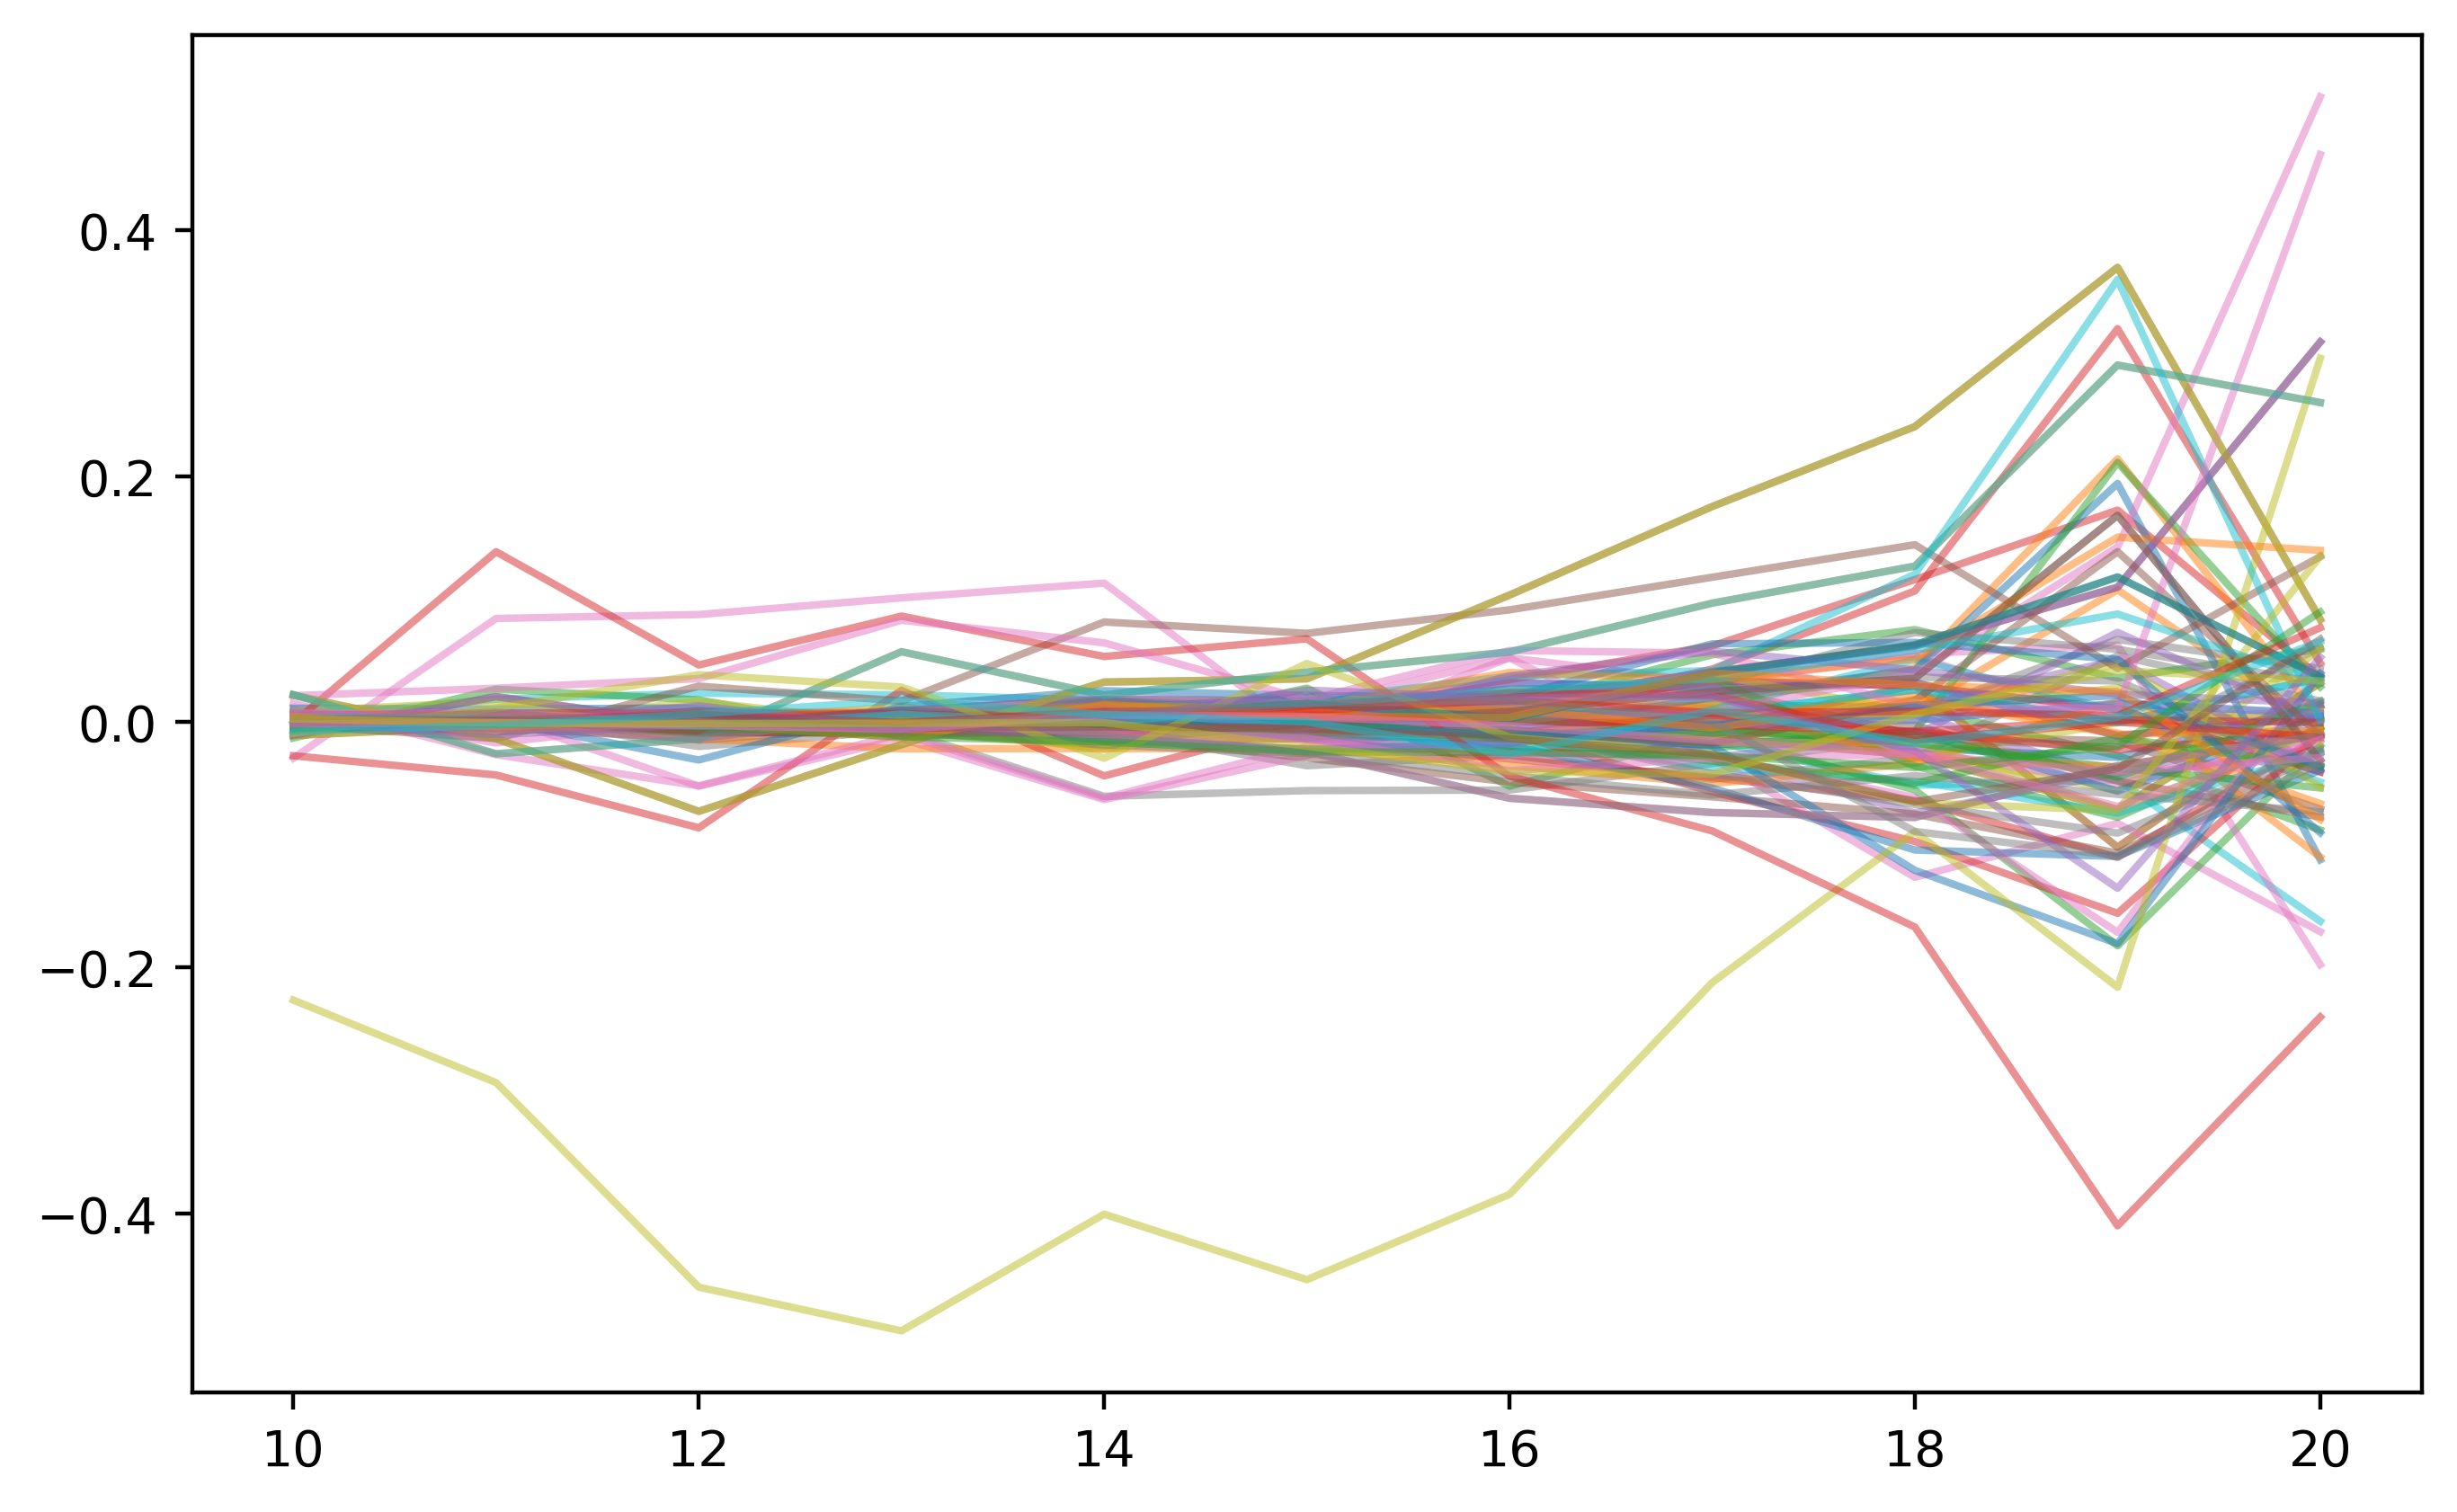

In [17]:
plt.figure(figsize=(8,5))
rand_sample = np.random.choice(np.arange(result['a'].shape[0]), size=100)
for ii in rand_sample:
    plt.plot(M_bins[:-1], result['a'][ii,:,0], alpha=0.5)

In [2]:
import numpy as np

In [9]:
arr = np.arange(5.,22.,.1)

In [12]:
np.round(arr, decimals=1)[2]

5.2

In [23]:
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    arr = hf['n'][150,0,:]

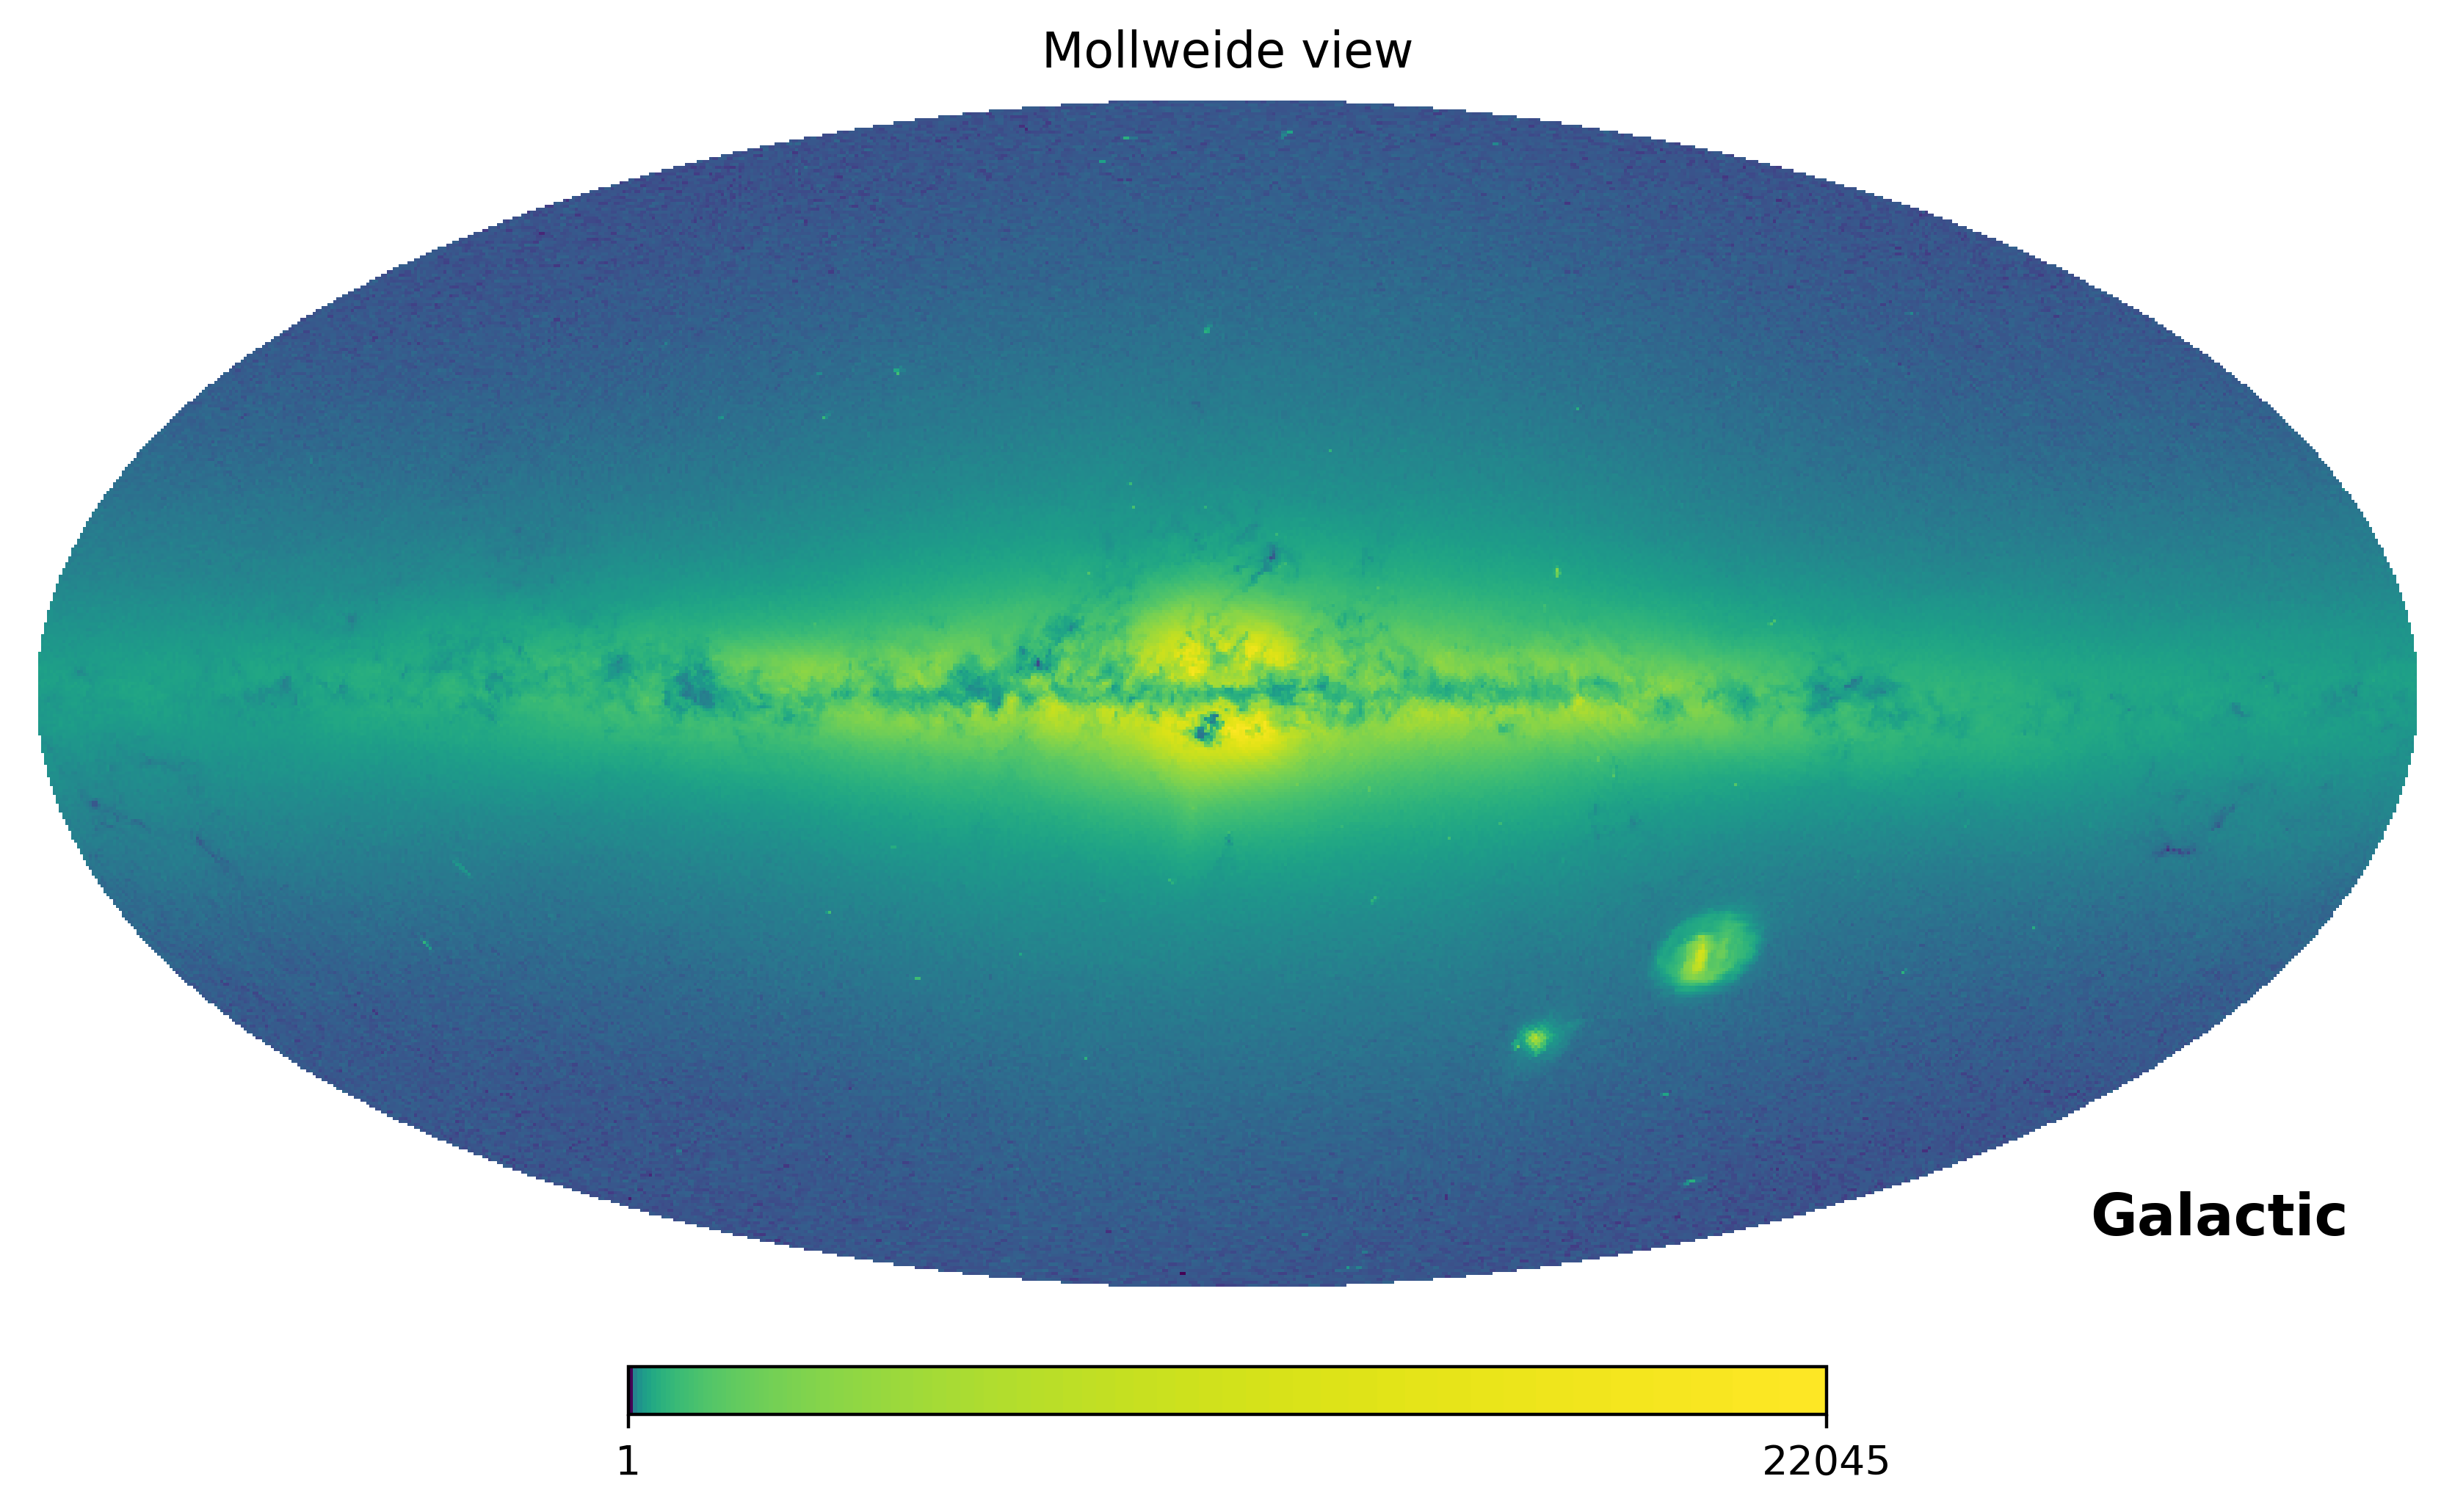

In [25]:
hp.mollview(arr, nest=True, coord=['C','G'], norm='log')

In [30]:
len(np.round(np.arange(5.,22.,.1), decimals=1))

170

In [31]:
hp.sphtfunc.alm2map?